# **현재 대분류 분류 모델 최고성능** 
- 현재 최고성능 train 0.92, test 0.87 (Gru + pooling, Bilstm)
- **Random over + under sampling** 

In [ ]:
# library 
import tensorflow as tf
import pandas as pd
import numpy as np
from tqdm import tqdm, tqdm_notebook
from sklearn.model_selection import train_test_split
import sys 
import math

# !pip install fasttext
import fasttext

import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('whitegrid')
plt.style.use("fivethirtyeight")
%matplotlib inline

# sampler
from imblearn.over_sampling import RandomOverSampler
from imblearn.under_sampling import RandomUnderSampler 

import warnings
warnings.filterwarnings('ignore')

/usr/local/lib/python3.7/dist-packages/sklearn/externals/six.py:31: FutureWarning: The module is deprecated in version 0.21 and will be removed in version 0.23 since we've dropped support for Python 2.7. Please rely on the official version of six (https://pypi.org/project/six/).
  "(https://pypi.org/project/six/).", FutureWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.neighbors.base module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.neighbors. Anything that cannot be imported from sklearn.neighbors is now part of the private API.
  warnings.warn(message, FutureWarning)


In [ ]:
# # preprocessing 
# def drop_token(x):
#     sw = ['부대사업','사업','부대','각호','판매업', '한다', '거나', '에게']   # stopwords
#     x = [word for word in x if not word in sw]
#     if len(x)>50:         # drop 
#       return x[:50]
#     else:
#       return x  
# data['token'] = data['token'].apply(drop_token)   # 미리 토큰 전처리 
# data_big = data[['company', 'big', 'token']]
# data_big.to_pickle('/content/drive/MyDrive/Colab Notebooks/Competition/KED 대상팀/data/final_data/대분류용data.pkl')

## 위와 같이 전처리 후 pkl로 저장함 (용량 감소를 위해 big과 company, 사업목적토큰만 저장)
data = pd.read_pickle('/content/drive/MyDrive/Colab Notebooks/Competition/KED 대상팀/data/final_data/대분류용data.pkl')

# 1. Sampling 

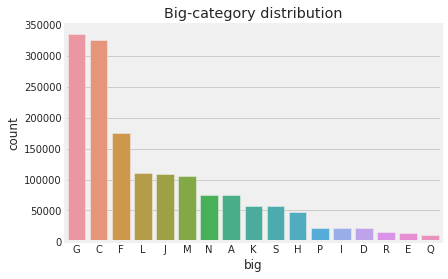

In [ ]:
sns.countplot(data=data, x='big', order = data['big'].value_counts().index)
plt.title('Big-category distribution')
plt.show()

대분류의 분포가 unbalanced한 것을 확인
> 매우 많은 G,C,F는 L,J,M에 맞춰서 Random undersampling   

> 매우 적은 P,I,D,R,E,Q는 N,A에 맞춰서 Random oversampling

In [ ]:
# undersampling 
data_under = data.query('big in ["G","C","F", "L", "J", "M"]')
X = data_under[['company', 'token']]
y = data_under['big']

us = RandomUnderSampler(random_state=0)   # 다른 파라미터는 조정 안함 
X_under, y_under = us.fit_resample(X, y)

undered = pd.DataFrame(X_under, columns=['company', 'token'])
undered['big'] = y_under
pd.Series(y_under).value_counts()

G    106443
F    106443
M    106443
L    106443
C    106443
J    106443
dtype: int64

In [ ]:
# oversampling 
data_over = data.query('big not in ["G","C","F", "L", "J", "M"]')
X = data_over[['company', 'token']]
y = data_over['big']

us = RandomOverSampler(random_state=0)
X_over, y_over = us.fit_resample(X, y)

overed = pd.DataFrame(X_over, columns=['company', 'token'])
overed['big'] = y_over
overed.big.value_counts()

I    75069
P    75069
R    75069
E    75069
N    75069
K    75069
S    75069
Q    75069
H    75069
D    75069
A    75069
Name: big, dtype: int64

In [ ]:
sample_data =pd.concat([overed, undered]).reset_index(drop=True)   # concat

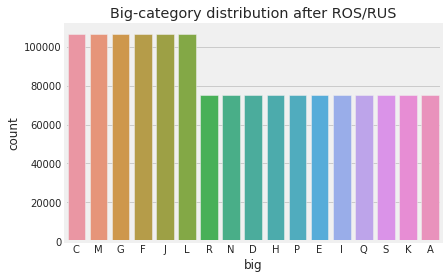

In [ ]:
sns.countplot(data=sample_data, x='big', order = sample_data['big'].value_counts().index)
plt.title('Big-category distribution after ROS/RUS')
plt.show()

-----------------------------------------------
# 2. Fasttext + Recurrent Modeling 


### 1) Preprocessing 

In [ ]:
EMBEDDING_DIM = 300   # fasttext 임베딩 차원 

def drop_token(x):
    sw = ['부대사업','사업','부대','각호','판매업', '한다', '거나', '에게']   # 불용어 제거 
    x = [word for word in x if not word in sw]

    if len(x)>50:   
      return x[:50]
    else:
      return x  # 중복 제거해봄 >> 이게 되게 안좋은가봐


# X, y train data 만들기 
def read_corpus(path):
    data = pd.read_pickle(path)
    data = data.query('big not in ["O","U","T"]')  # 나중에 out 얘네들 rule base로 쳐내야함 

    ## 이걸로 수정함 
    X = [x for x in data.iloc[:,-2].apply(drop_token)] 
    Y = pd.get_dummies(data['big']).values   # 대분류 get dummy로 펼치기 

    Xtrain, Xtest, Ytrain, Ytest = train_test_split(X, Y, test_size=0.2,
                                                    random_state=1214,
                                                    stratify=Y)
  
    # valid set 추가
    tr_x, val_x, tr_y, val_y = train_test_split(Xtrain, Ytrain, test_size=0.2,
                                                    random_state=1230,
                                                    stratify=Ytrain)
    
    return np.array(tr_x), np.array(Xtest), np.array(tr_y), np.array(Ytest), np.array(val_x), np.array(val_y)  # array 로 반환 


## max_len 제한 둔 패딩 
def pad(data, max_len=50):    
    if max_len == 0:
        max_len = max(len(tokens) for tokens in data)

    result = []
    for tokens in tqdm(data, desc='Padding'):
        if len(tokens) >= max_len:  ## max_len보다 크면 그냥 max_len까지만 자르기 
            result.append(tokens[:max_len])

        else:
            n_to_pad = max_len - len(tokens) 
            result.append(tokens + [''] * n_to_pad)

    return max_len, result


## 패딩하기 
def preprocess(tokenized_sentences):
    max_tokens, padded_sentences = pad(tokenized_sentences)
    return padded_sentences

### Sequence dataset 맞춤형 딥러닝 
class Dataset(tf.keras.utils.Sequence):
    fasttext_model_cache = {}
    
    def __init__(self, x_set, y_set, batch_size):
        self.x_set = x_set
        self.y_set = y_set
        self.batch_size = batch_size

        fasttext_model_path = '/content/drive/MyDrive/Colab Notebooks/Competition/KED 대상팀/cc.ko.300.bin' # 나중에 추가학습 시도하기 

        if fasttext_model_path not in Dataset.fasttext_model_cache:
            Dataset.fasttext_model_cache[fasttext_model_path] = fasttext.load_model(fasttext_model_path)  

        self.fasttext_model = Dataset.fasttext_model_cache[fasttext_model_path]

    def __len__(self):
        return math.ceil(len(self.x_set) / self.batch_size)   

    def __getitem__(self, idx):
        padded_sentences = self.x_set[idx * self.batch_size:(idx + 1) * self.batch_size]  
              
        word_vectors = [self.get_word_vectors(padded_sentence) for padded_sentence in padded_sentences]        
        batch_y = self.y_set[idx * self.batch_size:(idx + 1) * self.batch_size]
        
        return np.array(word_vectors), np.array(batch_y)
    
    ## word_vectors를 얻기 
    def get_word_vectors(self, words):
        result = []
        for word in words:
            if not word: 
                result.append(np.zeros((EMBEDDING_DIM,)))   # LSTM을 위한 zero padding 
            else:
                result.append(self.fasttext_model.get_word_vector(word))

        return np.array(result)

In [ ]:
# path = '/content/drive/MyDrive/Colab Notebooks/Competition/KED 대상팀/data/final_data/0504_alltoken.pkl'
path = '/content/drive/MyDrive/Colab Notebooks/Competition/KED 대상팀/data/final_data/대분류sample.pkl'   # sample data
batch_size =  128


#### X, y data 만들기 (train 내에서 split 한거임) + valid split까지 
train_sentences, test_sentences, train_labels, test_labels, valid_sentences, valid_labels = read_corpus(path)


#### train 
train_padded_sentences = preprocess(train_sentences)   # 패딩하기 
train_dataset = Dataset(train_padded_sentences, train_labels, batch_size)    # Dataset 제작 

### valid 
valid_padded_sentences = preprocess(valid_sentences)   # 패딩하기 
valid_dataset = Dataset(valid_padded_sentences, valid_labels, batch_size)    # Dataset 제작

### test 
test_padded_sentences = preprocess(test_sentences)       
test_batch_size = batch_size   # train과 동일하게 설정 
test_dataset = Dataset(test_padded_sentences, test_labels, test_batch_size)     

In [ ]:
print(train_dataset, valid_dataset, test_dataset)

### 2) Modeling
- Gru + Pooling concat

In [ ]:
from keras.models import Model
from keras.layers import Input, Dense, Embedding, SpatialDropout1D, concatenate
from keras.layers import GRU, Bidirectional, GlobalAveragePooling1D, GlobalMaxPooling1D
from keras.preprocessing import text, sequence
from keras.callbacks import Callback
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau   

In [ ]:
def build_model():
    inp = Input(shape=(None,EMBEDDING_DIM))
    x = Bidirectional(GRU(256, return_sequences=True))(inp)
    avg_pool = GlobalAveragePooling1D()(x)
    max_pool = GlobalMaxPooling1D()(x)
    conc = concatenate([avg_pool, max_pool])
    outp = Dense(17, activation="softmax")(conc)
    
    model = Model(inputs=inp, outputs=outp)
    model.summary()

    return model

model = build_model()  

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, None, 300)]  0                                            
__________________________________________________________________________________________________
bidirectional (Bidirectional)   (None, None, 512)    857088      input_1[0][0]                    
__________________________________________________________________________________________________
global_average_pooling1d (Globa (None, 512)          0           bidirectional[0][0]              
__________________________________________________________________________________________________
global_max_pooling1d (GlobalMax (None, 512)          0           bidirectional[0][0]              
______________________________________________________________________________________________

In [ ]:
batch_size =  128
epoch = 10

model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])    
history = model.fit(train_dataset, epochs=epoch, validation_data=valid_dataset)  

## 1 epoch에 5분정도  # ram도 12기가정도 먹음    

In [ ]:
test_loss, test_accuracy = model.evaluate(test_dataset)    
print('test_loss', test_loss)
print('test_accuracy', test_accuracy)   

loss: 0.2486 - accuracy: 0.9237 - val_loss: 0.4533 - val_accuracy: 0.8760 (21.05.12 기준)

In [ ]:
# plot 
import matplotlib.pyplot as plt
acc=history.history['accuracy']
val_acc=history.history['val_accuracy']
loss=history.history['loss']
val_loss=history.history['val_loss']
epochs=range(1,len(acc)+1)

plt.plot(epochs,acc,'g',label='training acc')
plt.plot(epochs,val_acc,'ro',label='validation acc')
plt.title('training and validation accuracy')
plt.legend()
plt.figure()
plt.plot(epochs,loss,'g',label='training loss')
plt.plot(epochs,val_loss,'ro',label='validation loss')
plt.title('training and validation loss')
plt.legend()    # lstmwltjd
plt.show()

In [ ]:
# model.save('/content/drive/MyDrive/Colab Notebooks/Competition/KED 대상팀/model/classfier.fasttext.model/dense+bigru_tok50_sam')

- Bilstm 

In [ ]:
def build_model():
    model = tf.keras.Sequential()
    model.add(tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(128, return_sequences=True), 
                                            input_shape=(None, EMBEDDING_DIM)))
    model.add(tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(128)))
    model.add(tf.keras.layers.Dense(64))
    model.add(tf.keras.layers.Dense(17, activation='softmax'))    ## 17개의 대분류 분류
    model.summary() 

    return model

model = build_model()    # 원래모델 

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
bidirectional_1 (Bidirection (None, None, 256)         439296    
_________________________________________________________________
bidirectional_2 (Bidirection (None, 256)               394240    
_________________________________________________________________
dense_1 (Dense)              (None, 64)                16448     
_________________________________________________________________
dense_2 (Dense)              (None, 17)                1105      
Total params: 851,089
Trainable params: 851,089
Non-trainable params: 0
_________________________________________________________________


In [ ]:
batch_size =  128
epoch = 10

model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])    
history = model.fit(train_dataset, epochs=epoch, validation_data=valid_dataset)  # 1 epoch에 13분 걸림 

loss: 0.2533 - accuracy: 0.9205 - val_loss: 0.4584 - val_accuracy: 0.8782   (21.05.12 기준)


In [ ]:
# model.save('/content/drive/MyDrive/Colab Notebooks/Competition/KED 대상팀/model/classfier.fasttext.model/bilstm_tok50_sam') 

In [ ]:
test_loss, test_accuracy = model.evaluate(test_dataset)    
print('test_loss', test_loss)
print('test_accuracy', test_accuracy)  

In [ ]:
# plot 
import matplotlib.pyplot as plt
acc=history.history['accuracy']
val_acc=history.history['val_accuracy']
loss=history.history['loss']
val_loss=history.history['val_loss']
epochs=range(1,len(acc)+1)

plt.plot(epochs,acc,'g',label='training acc')
plt.plot(epochs,val_acc,'ro',label='validation acc')
plt.title('training and validation accuracy')
plt.legend()
plt.figure()
plt.plot(epochs,loss,'g',label='training loss')
plt.plot(epochs,val_loss,'ro',label='validation loss')
plt.title('training and validation loss')
plt.legend()    # lstmwltjd
plt.show()

In [ ]:
# pred 반환 
y_pred = model.predict(test_dataset)
Y_pred_classes = np.argmax(y_pred,axis = 1) 
pd.Series(Y_pred_classes).value_counts()    # 예측값 분포 

---------------------


# 3. TF/IDF Modeling  

In [ ]:
sample_data.head(3)

,company,token,big
0,1000107,"[자동차, 정비, 자동차, 부속품, 자동차, 견인, 운수업, 철도, 차량, 정비, ...",S
1,1000206,"[산업, 용품, 세탁업, 가정용품, 세탁업, 세탁물, 공급, 섬유, 염색, 표백, ...",S
2,1000294,"[타이어, 공업, 발전, 조사, 연구, 회원, 공동, 이익, 증진, 타이어, 공업,...",S


In [ ]:
print('샘플링 후 data shape : ', sample_data.shape)
print('샘플링 전 원래 data shape : ', data.shape)

샘플링 후 data shape :  (1464417, 3)
샘플링 전 원래 data shape :  (1578712, 3)


전, 후 전체적인 데이터 양은 10만개정도 차이나는 수준(거의 비슷함) 

In [ ]:
X =  [x for x in sample_data.iloc[:,-2]]
Y = pd.get_dummies(sample_data['big']).values   # 대분류 get dummy로 펼쳐서 split

# split
Xtrain, Xtest, Ytrain, Ytest = train_test_split(X, Y, test_size=0.2, random_state=1214)
tr_x, val_x, tr_y, val_y = train_test_split(Xtrain, Ytrain, test_size=0.2, random_state=1214)  # valid set 추가
print(len(tr_x), len(val_x), len(Xtest))  # 100만개, 20만개, 30만개

937226 234307 292884


In [ ]:
tr_x[0]

['악세사리', '디자인', '의류', '디자인', '신발', '디자인']

### 1) TFIDF 


In [ ]:
%%time
# preprocessor = TfidfVectorizer(max_features=500)   # tf-idf
preprocessor = TfidfVectorizer(min_df=1, ngram_range=(1,1), lowercase=True, max_features=500)   
## 유니그램, frequency가 1이상인 것만 추출 
X_train_p = preprocessor.fit_transform(tr_x, tr_y).toarray()
X_valid_p = preprocessor.transform(val_x).toarray()    
X_test_p = preprocessor.transform(te_x).toarray()    

In [ ]:
print(X_train_p.shape, X_valid_p.shape, X_test_p.shape)  # 패딩 안해도될듯? 

In [ ]:
# 단어별 idf 출력 + 정렬해봄
from operator import itemgetter
words = []
for i, j in zip(preprocessor.vocabulary_, preprocessor.idf_):
  words.append((i, j))
words.sort(key=itemgetter(1))
pprint(words[490:])   # 클수록 자주 등장하는 애들임

### 2) Modeling 
- 단순 dense  (빠름)


In [ ]:
from keras.models import Model
from keras.layers import Input, Dense, Embedding, SpatialDropout1D, concatenate
from keras.layers import GRU, Bidirectional, GlobalAveragePooling1D, GlobalMaxPooling1D
from keras.preprocessing import text, sequence
from keras.callbacks import Callback

In [ ]:
n_features = 500      # tf-idf 차원
n_classes = 17        # out 제외

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, Bidirectional, Dense, LSTM, SimpleRNN, Dropout

model = Sequential()
model.add(Dense(3000, kernel_initializer= 'he_normal', activation='relu', input_dim=500))
model.add(Dropout(0.5))
model.add(Dense(1000, kernel_initializer= 'he_normal', activation='relu'))

model.add(Dense(300, kernel_initializer= 'he_normal', activation='relu'))   # 원래 50
model.add(Dropout(0.5))

model.add(Dense(17, activation='softmax'))
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_3 (Dense)              (None, 3000)              1503000   
_________________________________________________________________
dropout (Dropout)            (None, 3000)              0         
_________________________________________________________________
dense_4 (Dense)              (None, 1000)              3001000   
_________________________________________________________________
dense_5 (Dense)              (None, 300)               300300    
_________________________________________________________________
dropout_1 (Dropout)          (None, 300)               0         
_________________________________________________________________
dense_6 (Dense)              (None, 17)                5117      
Total params: 4,809,417
Trainable params: 4,809,417
Non-trainable params: 0
____________________________________________

In [ ]:
model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

In [ ]:
history = model.fit(X_train_p, tr_y, epochs=20, batch_size=512, validation_split=0.2)

In [ ]:
model.evaluate(X_test_p,te_y)  # 많이 오르긴함... 샘플링한게 

loss: 0.4107 - accuracy: 0.8549 - val_loss: 0.7005 - val_accuracy: 0.8032 (21.05.12 기준)

In [ ]:
import matplotlib.pyplot as plt
acc=history.history['accuracy']
val_acc=history.history['val_accuracy']
loss=history.history['loss']
val_loss=history.history['val_loss']
epochs=range(1,len(acc)+1)

plt.plot(epochs,acc,'g',label='training acc')
plt.plot(epochs,val_acc,'ro',label='validation acc')
plt.title('training and validation accuracy')
plt.legend()
plt.figure()
plt.plot(epochs,loss,'g',label='training loss')
plt.plot(epochs,val_loss,'ro',label='validation loss')
plt.title('training and validation loss')
plt.legend()
plt.show()

In [ ]:
# from sklearn.model_selection import StratifiedKFold   ## 층화추출도 해볼만함
# n_fold = 5  
# seed = 42

# cv = StratifiedKFold(n_splits = n_fold, shuffle=True, random_state=seed)

# for (i_trn, i_val) in enumerate(cv.split(Xtrain, Ytrain)):   # 초기 valid split
#     # print(f'training model for CV #{i}')

#     model.fit(Xtrain[i_trn], Ytrain[i_trn],
#             validation_data=(Xtrain[i_val], Ytrain[i_val]),
#             epochs=20,
#             batch_size=512)

- K-fold 모델링
- callback 
- Lstm 내 dropout (cell dropout 등)